# Clustering(클러스터링)
- K-Means 알고리즘을 활용해 유사한 집단별로 군집화
- 클러스터링 평가 지표인 '실루엣 계수'를 활용해 가장 잘 군집화된 K개의 군집 탐색

### K-Means(K-평균)
- 군집화(Clustering)에서 가장 일반적으로 사용되는 알고리즘
- K-평균은 군집 중심점(centorid)이라는 특정한 임의의 지점을 선택해 해당 중심에 가장 가까운 포인트들을 선택하는 군집화 기법
- 군집 중심점은 선택된 포인트의 평균 지점으로 이동하고 이동된 중심점에서다시 가까운 포인트를 선택, 다시 중심점을 평균 지점으로 이동하는 프로세스를 반복적으로 수행
- 모든 데이터 포인트에서 더이상 중심점의 이동이 없을 경우에 반복을 멈추고 해당 중심점에 속하는 데이터 포인트들을 군집화하는 기법

### 데이터
- 아래 사용된 데이터는 공개된 [goodreads.com](https://drive.google.com/uc?id=17G5_MeSWuhYnD4fGJMvKRSOlBqCCimxJ) 데이터 중 'Poetry' 장르의 interaction data입니다.
- 데이터의 구성은 다음과 같습니다.
- Columns
  - 1) user_id
  - 2) book_id
  - 3) rating


## **필요 라이브러리 import**

In [7]:
from google.colab import files

import math
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [8]:
from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.express as px

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **데이터 로드**
(1) book_poetry 데이터
- 36514개의 행과 29개의 컬럼으로 구성되어 있음

(2) interactions_poetry 데이터
- 

In [10]:
file_path = "/content/drive/MyDrive/AIFFEL/Hackathon/Toy_Data/action_data.csv"

action = pd.read_csv(file_path)

In [11]:
action.head()

,Unnamed: 0,user_id,book_id,rating
0,0,8842281e1d1347389f2ab93d60773d4d,1384,4
1,1,8842281e1d1347389f2ab93d60773d4d,1376,4
2,2,8842281e1d1347389f2ab93d60773d4d,30119,5
3,4,72fb0d0087d28c832f15776b0d936598,30119,3
4,5,ab2923b738ea3082f5f3efcbbfacb218,240007,4


In [12]:
print(action.shape)

(1313610, 4)


In [15]:
# 전체 330만 개 데이터 중 일부 샘플 추출
action_sample = action.loc[action['user_id'].isin(random.sample(list(action['user_id'].unique()), k=1000000))]

ValueError: ignored

In [16]:
user_unique = action['user_id'].unique()
user_to_idx = {v:k for k, v in enumerate(user_unique)}

In [17]:
action['new_user_id'] = action['user_id'].apply(lambda x:user_to_idx[x])
action

,Unnamed: 0,user_id,book_id,rating,new_user_id
0,0,8842281e1d1347389f2ab93d60773d4d,1384,4,0
1,1,8842281e1d1347389f2ab93d60773d4d,1376,4,0
2,2,8842281e1d1347389f2ab93d60773d4d,30119,5,0
3,4,72fb0d0087d28c832f15776b0d936598,30119,3,1
4,5,ab2923b738ea3082f5f3efcbbfacb218,240007,4,2
...,...,...,...,...,...
1313605,2734340,148e49f7ed14137ff13a9a31c770487d,2547,5,282411
1313606,2734341,da6f9516279ed671027308abd21318bd,11047097,4,282412
1313607,2734343,594c86711bd7acdaf655d102df52a9cb,7433930,5,282413
1313608,2734348,594c86711bd7acdaf655d102df52a9cb,16170625,5,282413


In [18]:
del action['user_id']

## **클러스터링**

100%|██████████| 29/29 [14:04<00:00, 29.11s/it]


Text(0, 0.5, 'Inertia')

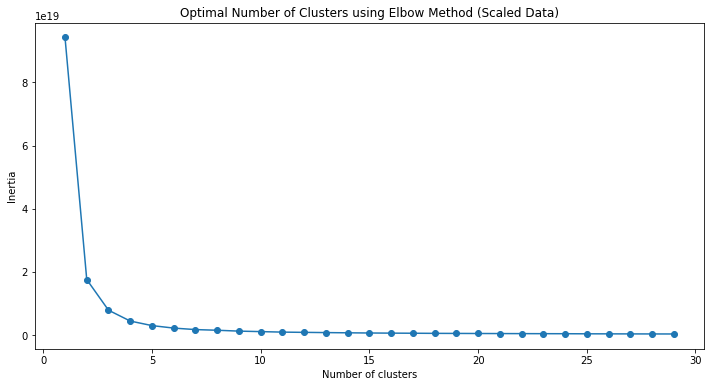

In [19]:
sse = []
k_list = range(1, 30)
for k in tqdm(k_list):
    km = KMeans(n_clusters=k)
    km.fit(action)
    sse.append([k, km.inertia_])
    
oca_results_scale = pd.DataFrame({'Cluster': range(1,30), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

## Silhouette Score 비교

(1) 실루엣 분석
- 각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지 나타남
- 효율적으로 잘 분리되었다는 것은 다른 군집과의 거리는 떨어져 있고 동일 군집끼리의 데이터는 서로 가깝게 잘 뭉쳐 있다는 의미
- 군집화가 잘 될수록, 개별 군집은 비슷한 정도의 여유 공간 가지고 떨어져 있음
- 실루엣 분석은 실루엣 계수를 기반으로 함

(2) 실루엣 계수
- 개별 데이터가 가지는 군집화 지표
- 해당 데이터가 같은 군집 내의 데이터와 얼마나 가깝게 군집화 돼있고, 다른 군집에 있는 데이터와는 얼마나 멀리 분리돼 있는지 나타내는 지표
- -1에서 1사이의 값을 가지며, 1로 가까워 질수록 근처의 군집과 더 멀리 떨어져 있다는 것이고, 0에 가까울 수록 근처의 군집과 가까워 진다는 것

(3) 좋은 군집화의 기준
- 전체 실루엣 개수의 평균값은 0 ~ 1사이의 값을 가지며, 1에 가까울 수록 좋음
- 전체 실루엣 계수의 평균값과 더불어 개별 군집의 평균값의 편차가 작아야 함
- 즉, 개별 군집의 실루엣 계수 평균값이 전체 실루엣 계수의 평균값에서 크게 벗어나지 않는 것이 중요
- 만약 전체 실루엣 계수의 평균값은 높지만, 특정 군집의 실루엣 계수 평균값만 유난히 높고 다른 군집들의 평균값은 낮으면 좋은 군집화가 아님

In [ ]:
kmeans_2 = KMeans(n_clusters = 2).fit(action)
kmeans_3 = KMeans(n_clusters = 3).fit(action)
kmeans_4 = KMeans(n_clusters = 4).fit(action)
kmeans_5 = KMeans(n_clusters = 5).fit(action)
kmeans_6 = KMeans(n_clusters = 6).fit(action)

print('KMeans Scaled Silhouette Score 2: {}'.format(silhouette_score(action, kmeans_2.labels_, metric='euclidean')))
print('KMeans Scaled Silhouette Score 3: {}'.format(silhouette_score(action, kmeans_3.labels_, metric='euclidean')))
print('KMeans Scaled Silhouette Score 4: {}'.format(silhouette_score(action, kmeans_4.labels_, metric='euclidean')))
print('KMeans Scaled Silhouette Score 5: {}'.format(silhouette_score(action, kmeans_5.labels_, metric='euclidean')))
print('KMeans Scaled Silhouette Score 6: {}'.format(silhouette_score(action, kmeans_6.labels_, metric='euclidean')))

Action 데이터 셋을 이용한 클러스터 평가
- Action 데이터 셋의 군집화 결과를 실루엣 분석으로 평가해보기
- silhouette_samples()와 silhouette_score()를 이용


In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, random_state = 0).fit(action_final)
action['cluster'] = kmeans.labels_

In [ ]:
# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score

# 모든 개별 데이터에 실루엣 계수값을 구함
score_samples = silhouette_samples(action, action['cluster'])
print('silhouette_samples() return 값의 shape', score_samples.shape)

In [ ]:
# action_sample에 실루엣 계수 컬럼 추가
action['silhouette_coeff'] = score_samples

In [ ]:
# 모든 데이터의 평균 실루엣 계수값 구하기
average_score = silhouette_score(action, action['cluster'])
print('데이터셋 Silhouette Anlysis Score:'.format(average_score))

action.head()

In [ ]:
# 군집별 평균 실루엣 계수 조회
action.groupby('cluster')['silhouette_coeff'].mean()

클러스터별 평균 실루엣 계수의 시각화를 통한 클러스터 개수 최적화 방법
- 아래 그래프는 개별 군집에 속하는 데이터의 실루엣 계수를 2차원으로 나타낸 것
- K- 평균 군집을 수행했을 때, 개별 군집별 평균 실루엣 계수 값을 시각화해서 군집의 개수를 정하는데 도움을 줌
  - x축: 실루엣 계수 값
  - y축: 개별 군집과 이에 속하는 데이터
    - 숫자 값으로 어떤 군집인지 표기. 이에 해당되는 데이터는 Y축 높이로 추측
  - 점선: 전체 평균 실루엣 계수 값

In [ ]:
# 여러 개의 클러스터링 갯수를 list로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수
def visualize_silhouette(cluster_lists, X_features):
  # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 개수별로 클러스터링을 적용하고 실루엣 개수를 구함
  n_cols = len(cluster_lists)

  # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
  fig, axs = plt.subplots(figsize = (4*n_cols, 4), nrows = 1, ncols = n_cols)

  # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
  for ind, n_cluster in enumerate(cluster_lists):
    
    # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
    clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
    cluster_labels = clusterer.fit_predict(X_features)

    sil_avg = silhouette_score(X_features, cluster_labels)
    sil_values = silhouette_samples(X_features, cluster_labels)

    y_lower = 10
    axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
    axs[ind].set_xlabel("The silhouette coefficient values")
    axs[ind].set_ylabel("Cluster label")
    axs[ind].set_xlim([-0.1, 1])
    axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
    axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
    axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
    for i in range(n_cluster):
      ith_cluster_sil_values = sil_values[cluster_labels==i]
      ith_cluster_sil_values.sort()

      size_cluster_i = ith_cluster_sil_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_cluster)
      axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
      axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      y_lower = y_upper + 10

      axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [ ]:
visualize_silhouette([2, 3, 4, 5], action)

K-평균을 이용한 'action_final' 데이터 세트 군집화

In [ ]:
print(kmeans.labels_)

In [ ]:
pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(action)

action_final['pca_x'] = pca_transformed[:,0]
action_final['pca_y'] = pca_transformed[:,1]
action_final.head()

In [ ]:
marker0_ind = action_final[action['cluster']==0].index 
marker1_ind = action_final[action['cluster']==1].index 
marker2_ind = action_final[action['cluster']==2].index

plt.scatter(x=action_final.loc[marker0_ind, 'pca_x'], y = action.loc[marker0_ind, 'pca_y'], marker = 'o')
plt.scatter(x=action_final.loc[marker1_ind, 'pca_x'], y = action.loc[marker1_ind, 'pca_y'], marker = 's')
plt.scatter(x=action_final.loc[marker2_ind, 'pca_x'], y = action.loc[marker2_ind, 'pca_y'], marker = '^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

In [ ]:
action['label'] = kmeans.labels_

In [ ]:
# k-means 라벨 값으로 countplot
sns.countplot(x = 'label', palette = 'Accent', data = action_final)
plt.show()